## Introudction
**This analysis reframes logistic regression from a pure prediction task to a decision support problem. The objective is not to maximize accuracy, but to minimize decision harm by accounting for asymmetric error costs when flagging patients for further diagnostic evaluation.**


## STEP 1 : Load + Minimal Clean


In [6]:
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv("~/Downloads/BCdata.csv")

# Drop non-informative columns
df = df.drop(columns=["Unnamed: 32", "id"], errors="ignore")

# Define decision target
df["target"] = (df["diagnosis"] == "M").astype(int)

# Remove original label column
df_model = df.drop(columns=["diagnosis"])

# Handle missing values conservatively
df_model = df_model.dropna()

# Feature matrix and target vector
X = df_model.drop(columns=["target"])
y = df_model["target"]

X.shape, y.shape



## STEP 2 : Split

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    stratify=y,
    random_state=42
)


## STEP 3 : Train baseline model

In [8]:
from sklearn.linear_model import LogisticRegression

baseline_model = LogisticRegression(
    max_iter=1000,
    solver="liblinear"
)

baseline_model.fit(X_train, y_train)



LogisticRegression(max_iter=1000, solver='liblinear')

## STEP 4 : Get probabilities

In [9]:
# Probabilities for positive (malignant) class
y_proba = baseline_model.predict_proba(X_test)[:, 1]

y_proba[:5]


## STEP 5 : Define Decision Scenarios

In [10]:
scenarios = {
    "balanced_costs": {"COST_FP": 1, "COST_FN": 1},
    "high_FN_cost": {"COST_FP": 1, "COST_FN": 10},
    "resource_constrained": {"COST_FP": 5, "COST_FN": 10}
}


## STEP 6:  Scenario-Based Threshold Simulation

In [11]:
from sklearn.metrics import confusion_matrix

thresholds = np.linspace(0, 1, 101)
scenario_results = []

for scenario, costs in scenarios.items():
    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        
        expected_cost = (
            costs["COST_FP"] * fp +
            costs["COST_FN"] * fn
        )
        
        scenario_results.append({
            "scenario": scenario,
            "threshold": t,
            "false_positives": fp,
            "false_negatives": fn,
            "expected_cost": expected_cost
        })

scenario_df = pd.DataFrame(scenario_results)

scenario_df.head()


,scenario,threshold,false_positives,false_negatives,expected_cost
0,balanced_costs,0.00,90,0,90
1,balanced_costs,0.01,29,0,29
2,balanced_costs,0.02,22,0,22
3,balanced_costs,0.03,15,0,15
4,balanced_costs,0.04,14,0,14


## Cost vs Threshold Plot (Per Scenario)

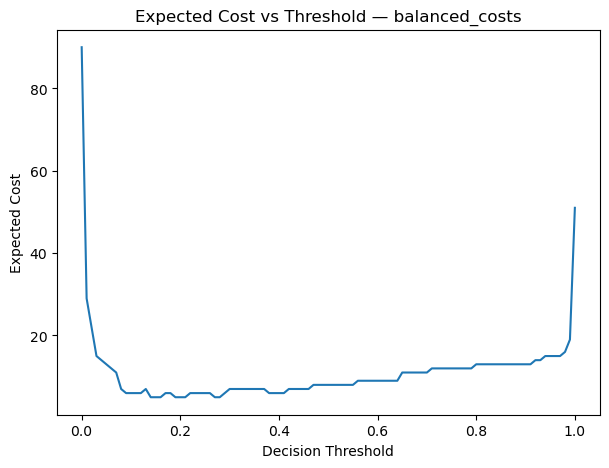

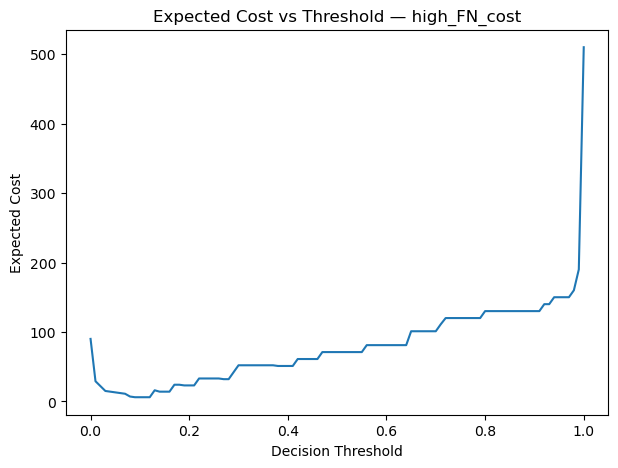

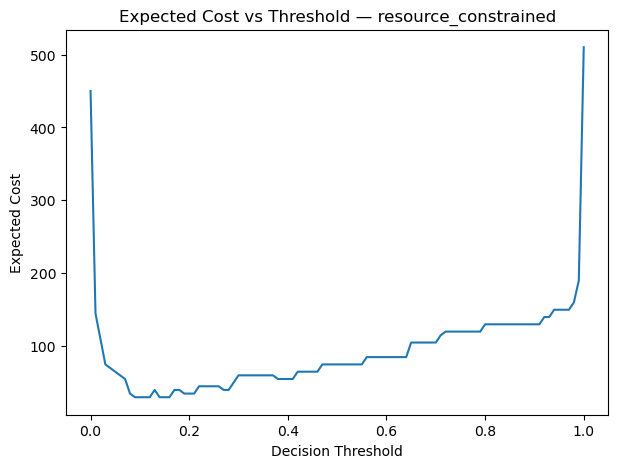

In [16]:
import matplotlib.pyplot as plt

for scenario in scenario_df["scenario"].unique():
    
    subset = scenario_df[scenario_df["scenario"] == scenario]
    
    plt.figure(figsize=(7,5))
    plt.plot(subset["threshold"], subset["expected_cost"])
    
    plt.xlabel("Decision Threshold")
    plt.ylabel("Expected Cost")
    plt.title(f"Expected Cost vs Threshold — {scenario}")
    
    plt.show()


**The expected cost curves illustrate how decision thresholds influence overall harm under different operational assumptions.**

- In the balanced-cost scenario, cost decreases rapidly from very low thresholds and reaches a broad low-cost region between approximately 0.15 and 0.4, indicating a range of thresholds that balance false positives and false negatives effectively. This suggests moderate robustness to threshold selection when error costs are symmetric.

- When false-negative costs are substantially higher, the minimum expected cost shifts toward very low thresholds. This reflects a strategy that prioritizes recall and aggressively flags patients to minimize missed malignant cases, even at the expense of increased false positives.

- Under resource-constrained conditions, the optimal threshold moves upward relative to the high false-negative scenario. Extremely low thresholds generate excessive false positives and high operational burden, while moderate thresholds provide a more practical balance between risk detection and capacity limitations.

- Across all scenarios, the optimal decision threshold varies considerably, demonstrating that threshold selection is inherently context-dependent. These results reinforce that fixed thresholds such as 0.5 are rarely optimal for real-world decision support systems.



## Precision–Recall Curve with Scenario Operating Points

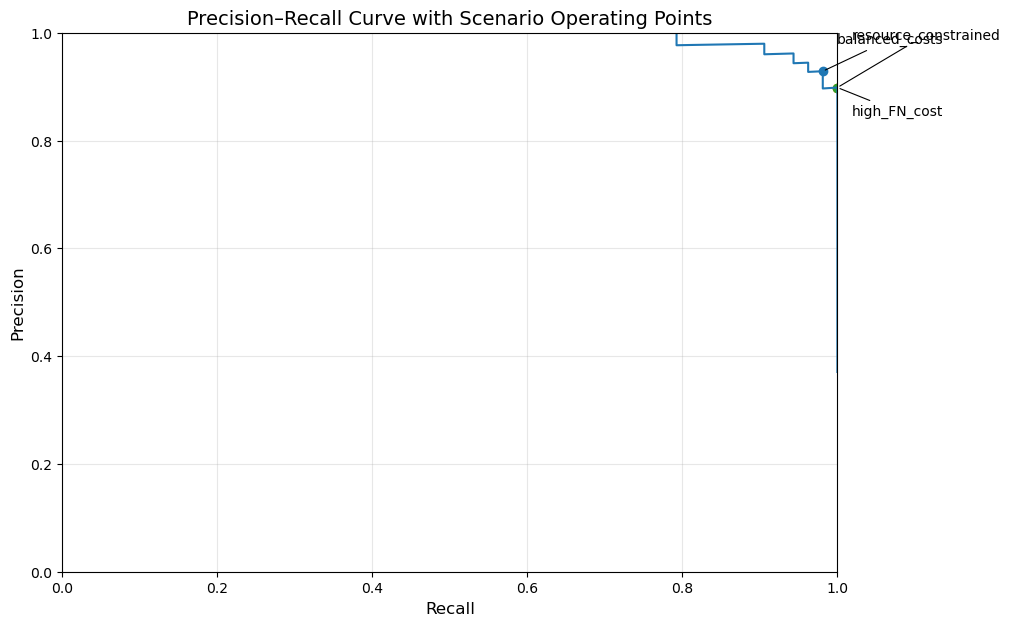

In [20]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, pr_thresholds = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(10,7))

# Main PR curve
plt.plot(recall, precision)

plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.title("Precision–Recall Curve with Scenario Operating Points", fontsize=14)

# Vertical staggering offsets
y_offsets = [20, -20, 35, -35, 50]

for i, (_, row) in enumerate(optimal_thresholds.iterrows()):
    
    t = row["threshold"]
    scenario = row["scenario"]
    
    y_pred = (y_proba >= t).astype(int)
    
    p = precision_score(y_test, y_pred)
    r = recall_score(y_test, y_pred)
    
    # Plot point
    plt.scatter(r, p)
    
    # Offset label vertically to avoid collisions
    offset = y_offsets[i % len(y_offsets)]
    
    plt.annotate(
        scenario,
        xy=(r, p),
        xytext=(10, offset),
        textcoords="offset points",
        fontsize=10,
        arrowprops=dict(arrowstyle="-", linewidth=0.8)
    )

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)

plt.show()



The precision–recall curve indicates strong baseline discrimination, with high precision maintained across a wide range of recall values.

Scenario-specific operating points cluster along the upper-right region of the curve, reflecting high detection performance under all decision contexts.

The balanced-cost scenario selects an operating point that preserves both high precision and high recall, reflecting a moderate and stable trade-off.

When false-negative costs dominate, the operating point shifts toward maximum recall, accepting a modest reduction in precision to minimize missed malignant cases.

Under resource constraints, the threshold moves slightly toward higher precision, reducing unnecessary follow-ups while still capturing most high-risk cases.

These results demonstrate that different operational priorities primarily adjust threshold selection along a fixed performance frontier, rather than requiring different models.



## STEP 7: Optimal Threshold per Scenario

In [13]:
optimal_thresholds = (
    scenario_df
    .loc[scenario_df.groupby("scenario")["expected_cost"].idxmin()]
    .sort_values("scenario")
)

optimal_thresholds


,scenario,threshold,false_positives,false_negatives,expected_cost
14,balanced_costs,0.14,4,1,5
110,high_FN_cost,0.09,6,0,6
211,resource_constrained,0.09,6,0,30


## STEP 8️: Precision–Recall at Operating Points

In [14]:
from sklearn.metrics import precision_score, recall_score

pr_results = []

for _, row in optimal_thresholds.iterrows():
    t = row["threshold"]
    scenario = row["scenario"]
    
    y_pred = (y_proba >= t).astype(int)
    
    pr_results.append({
        "scenario": scenario,
        "threshold": t,
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred)
    })

pr_df = pd.DataFrame(pr_results)

pr_df


,scenario,threshold,precision,recall
0,balanced_costs,0.14,0.928571,0.981132
1,high_FN_cost,0.09,0.898305,1.000000
2,resource_constrained,0.09,0.898305,1.000000


## STEP 9 : (Optional but Nice) Sort Results for Reporting

In [15]:
scenario_df.sort_values(
    ["scenario", "expected_cost"]
).groupby("scenario").head(5)


,scenario,threshold,false_positives,false_negatives,expected_cost
14,balanced_costs,0.14,4,1,5
15,balanced_costs,0.15,4,1,5
16,balanced_costs,0.16,4,1,5
19,balanced_costs,0.19,3,2,5
20,balanced_costs,0.20,3,2,5
110,high_FN_cost,0.09,6,0,6
111,high_FN_cost,0.10,6,0,6
112,high_FN_cost,0.11,6,0,6
113,high_FN_cost,0.12,6,0,6
109,high_FN_cost,0.08,7,0,7


Decision Trade-off Analysis

Evaluation across multiple operational scenarios demonstrates that optimal decision thresholds vary substantially depending on error cost assumptions.

Key insights:

Scenarios prioritizing high false-negative costs favor lower thresholds and higher recall.

Resource-constrained scenarios shift thresholds upward to control false positives.

No single threshold performs optimally across all contexts.

These findings highlight the necessity of scenario-aware evaluation when deploying ML models in real-world decision support systems.